In [1]:
#q15 This is importing all packages
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import svm
import pandas as pd
import numpy as np
import re, json, datetime, pytz
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
#q15 This is importing all packages

In [2]:
############### The function below retrieves/appends the data required after reading the files ###############
def get_data(text,return_day_count=False,return_hour_count=False):
    with open(text+'.txt', 'r',encoding="utf8") as f:
        retweet_count,month,day,hour,followers,place,title,time = [],[],[],[],[],[],[], []
        pst_tz = pytz.timezone('US/Pacific') 
        for line in f:
            tweet = json.loads(line)
            retweet_count.append(tweet['metrics']['citations']['total']) 
            month.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz).month)
            day.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz).day)
            hour.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz).hour)
            followers.append(tweet['author']['followers'])
            time.append(datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz))
            place.append(tweet['tweet']['user']['location'])
            title.append(tweet['title'])
    
    d = {'retweet_count':retweet_count,'month':month,'day':day,'hour':hour,
    'followers':followers,'time':time,'place':place,'title':title}
    df = pd.DataFrame(d)
    day_count = np.array(month)*31 + np.array(day) - 44
    hour_count = (day_count-1)*24 + np.array(hour)
    if return_day_count:
        df['day_count'] = day_count
    if return_hour_count:
        df['hour_count'] = hour_count
    return df   
############### The function below retrieves/appends the data required after reading the files ###############

In [3]:
# get data based on part 1 for superbowl                 
superbowl = get_data('tweets_#superbowl')
massachusetts = ['massachusetts', 'boston', 'ma']
washington = ['washington','seattle','kirkland','wa','wash']

superbowl['place_id']=None
any_in = lambda a, b:not set(a).isdisjoint(b)
for i in range(len(superbowl)):
    if i%5000==0:
        print(i)
    place_list = re.sub('[^a-zA-Z]', ' ', superbowl.loc[i,'place']).lower().split(' ')
    if any_in(place_list, massachusetts):
        superbowl.loc[i, 'place_id'] = 1
    elif any_in(place_list, washington):
        superbowl.loc[i, 'place_id'] = 0

#To save the dataframe and load it
#superbowl.to_pickle('superbowl')
#superbowl = pd.read_pickle('superbowl')
wash_mass = superbowl[superbowl['place_id']>=0]
wash_mass = wash_mass.reset_index()

#Cleaning the tweet text
stop_words = text.ENGLISH_STOP_WORDS
corpus = []
ps = PorterStemmer()
for i in range(len(wash_mass)):
    text = re.sub('[^a-zA-Z]', ' ', wash_mass.loc[i,'title']).lower().split()
    text = [ps.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    corpus.append(text)
    
#Splitting into training and test sets    
y = wash_mass['place_id'].tolist()
train_corpus,test_corpus,y_train,y_test = train_test_split(corpus,y,test_size=0.2,random_state=0)
tfidf = TfidfVectorizer(min_df=5)
tfidf_matrix_train = tfidf.fit_transform(train_corpus).toarray()
tfidf_matrix_test = tfidf.transform(test_corpus).toarray()

#Using LSI for dimensionality reduction
svd = TruncatedSVD(n_components = 50, random_state = 0)
X_train = svd.fit_transform(tfidf_matrix_train)
X_test = svd.transform(tfidf_matrix_test)



0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
485000
490000
495000
500000
505000
510000
515000
520000
525000
530000
535000
540000
545000
550000
555000
560000
565000
570000
575000
580000
585000
590000
595000
600000
605000
610000
615000
620000
625000
630000
635000
640000
645000
650000
655000
660000
665000
670000
675000
680000
685000
690000
695000
700000
705000
710000
715000
720000
725000
730

In [4]:
# Set up the confustion matrix 

class_names = ['Washington', 'Massachusetts']
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)

# This is for svm only 
# draw roc curve
def plot_roc_curve(method, fpr, tpr, auc):
    plt.figure(figsize=(15,9))
    plt.plot(fpr, tpr, color='deeppink', lw=2, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve ('+method+')', fontsize=23)
    plt.legend(loc="lower right")
    plt.show()

Accuracy is 0.7315288220551378
Precision is 0.7952099965289829
Recall is 0.5231788079470199
[[5006  590]
 [2088 2291]]


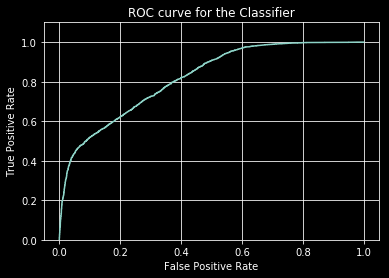

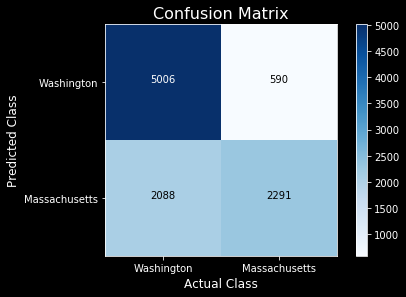

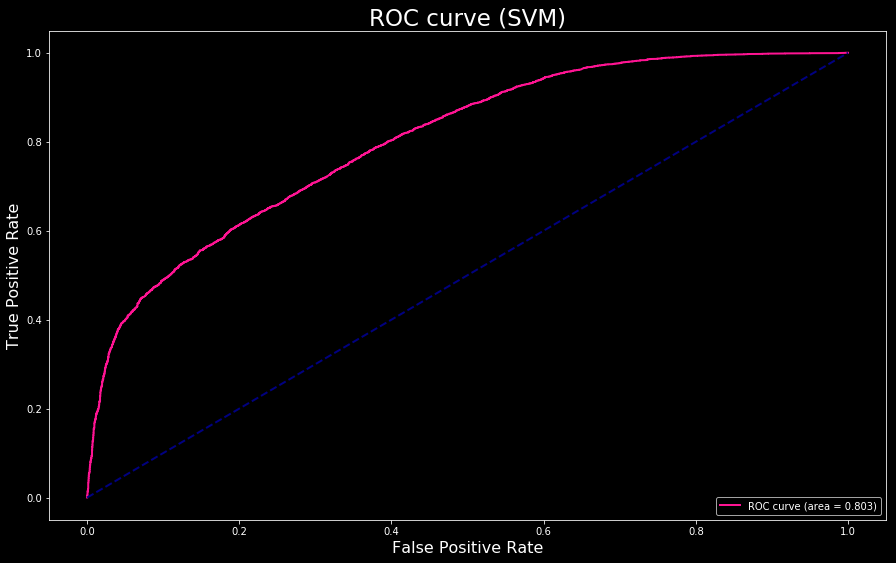

accuracy:
0.7118796992481203
precision:
0.841890049977283
recall:
0.42315597168303265
confusion matrix:
[[5248  348]
 [2526 1853]]


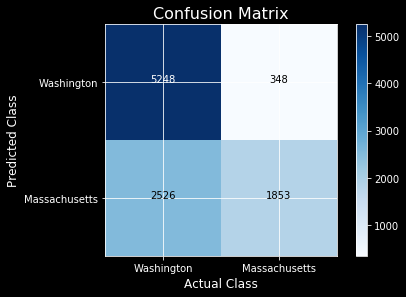

Accuracy is 0.6723809523809524
Precision is 0.6471523178807947
Recall is 0.5578899292075816
[[4264 1332]
 [1936 2443]]


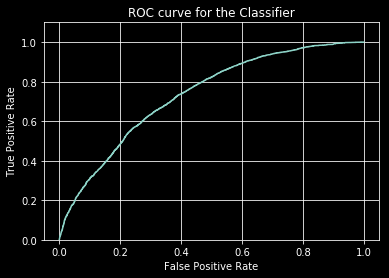

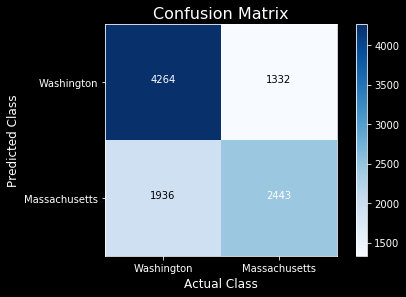

Accuracy is 0.718796992481203
Precision is 0.7151448879168945
Recall is 0.5973966659054578
[[4554 1042]
 [1763 2616]]


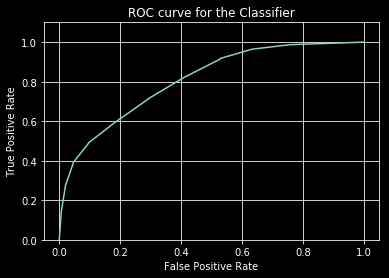

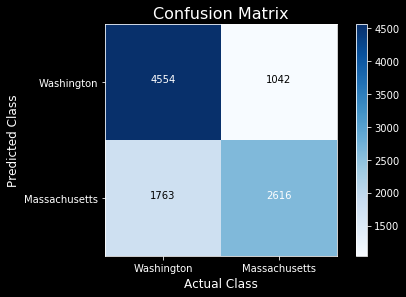

Accuracy is 0.7355388471177945
Precision is 0.7408022130013832
Recall is 0.6115551495775291
[[4659  937]
 [1701 2678]]


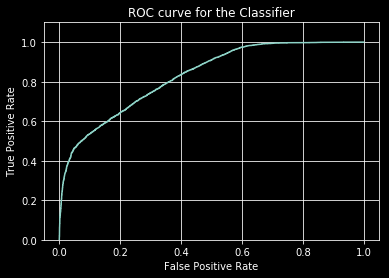

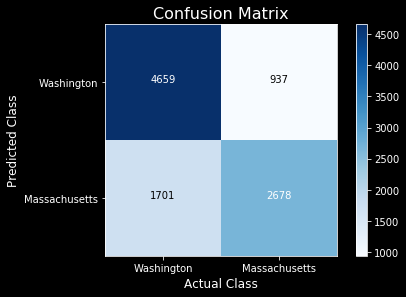

Accuracy is 0.715187969924812
Precision is 0.7284610814022578
Recall is 0.5599451929664306
[[4682  914]
 [1927 2452]]


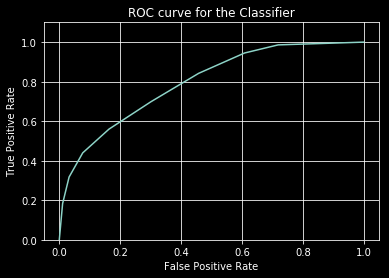

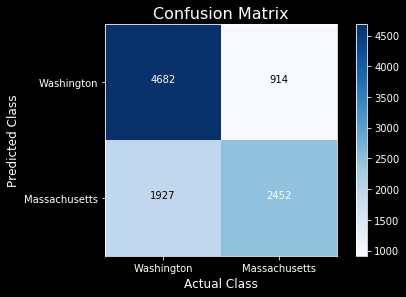

In [6]:
def classification(classifier):
    plt.grid(zorder=0)
    plt.style.use('dark_background')
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print('Accuracy is',(cm[0,0] + cm[1,1])/cm.sum())
    print('Precision is',cm[1,1] / (cm[1,1] + cm[0,1]))
    print('Recall is',cm[1,1] / (cm[1,1] + cm[1,0]))
    print(confusion_matrix(y_test, y_pred))
    y_pred_prob = classifier.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
       
    plt.plot(fpr,tpr)
    plt.title('ROC curve for the Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim(0,1.1)
    plt.show()
    
    title = 'Confusion Matrix'
    plot_confusion_matrix(cm, classes=class_names, title=title)
    plt.show()

#Logistic Regression
classification(LogisticRegression(random_state = 0))

#Soft margin SVM
parameters = {'gamma':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
svm_classifier = svm.SVC(probability=True)
svm_search = GridSearchCV(svm_classifier, parameters, cv=5)
svm_classifier.fit(X_train, y_train)
svm_label_true, svm_label_predicted = y_test, svm_classifier.predict(X_test)
svm_label_score_predicted = svm_classifier.decision_function(X_test) # use decisioin_function to get better curve

# plot ROC curve
svm_fpr, svm_tpr, svm_thresholds = roc_curve(svm_label_true, svm_label_score_predicted)
svm_roc_auc = auc(svm_fpr, svm_tpr)
plot_roc_curve('SVM', svm_fpr, svm_tpr, svm_roc_auc)

accuracy = []
precision = []
recall = []

# calculate accuracy, recall and precision
svm_acc = metrics.accuracy_score(svm_label_true, svm_label_predicted)
accuracy.append(svm_acc)
print ("accuracy:")
print (svm_acc)
svm_pre = metrics.precision_score(svm_label_true, svm_label_predicted)
precision.append(svm_pre)
print ("precision:")
print (svm_pre)
svm_recall = metrics.recall_score(svm_label_true, svm_label_predicted)
recall.append(svm_recall)
print ("recall:")
print (svm_recall)

# calculate and plot non-normalized confusion matrix
print ("confusion matrix:")
svm_conf_mat = metrics.confusion_matrix(svm_label_true, svm_label_predicted)
print (svm_conf_mat)
plt.figure()
plt.grid(zorder=0)
plt.style.use('dark_background')
title = 'Confusion Matrix'
plot_confusion_matrix(svm_conf_mat, classes=class_names, title=title)
plt.show()

#Naive Bayes Classifier
classification(GaussianNB())

#Random Forest Classifier 
classification(RandomForestClassifier(n_estimators=10))

#Neural network classifier
classification(MLPClassifier())

#KNN Classifier
classification(KNeighborsClassifier(n_neighbors=8))